In [3]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def weighted_die(num_steps):
    probabilities = np.array([3,3,1,1,1,1])
    states = np.zeros(6)
    current = np.random.randint(1,7)
    for n in range(num_steps):
        proposed = np.random.randint(1,7)
        r = np.random.random_sample()
        if current != proposed:
            p_accept = np.minimum(1, (probabilities[proposed-1]/probabilities[current-1]))
            if r < p_accept:
                current = proposed
        states[current-1] += 1
        earnings = np.sum(states[:2]) - np.sum(states[2:])
    return states, earnings 

In [5]:
def random_S(L):
    S = np.random.rand(L,L)
    for i in range(L):
        for j in range(L):
            if S[i,j] > .5:
                S[i,j] = 1
            else:
                S[i,j] = -1
    return S

In [6]:
def two_dim_ising(L, temp, num_steps):
    N = L**2
    U = np.zeros(num_steps+1)
    M = np.zeros(num_steps+1)
    X = np.zeros(num_steps+1)
    C = np.zeros(num_steps+1)
    
    S = random_S(L)
                
    E = energy(S)
    s = net_spin(S)
    
    E_ave = E
    E_square_ave = E**2
    s_ave = s
    s_square_ave = s**2
    
    U[0] = E_ave/N
    M[0] = s_ave/N
    X[0] = (1/(N*temp))*(s_square_ave - s_ave**2)
    C[0] = (1/(N*temp**2))*(E_square_ave - E_ave**2)
     
    for n in range(num_steps):
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)
        delta = delta_E(S, i, j)
        if delta <= 0:
            S[i,j] *= -1
            E += delta
            if S[i,j] < 0:
                s -= 2
            else:
                s += 2
        else:
            r = np.random.random_sample()
            if r < np.exp(-1*delta/temp):
                S[i,j] *= -1
                E += delta
                if S[i,j] < 0:
                    s -= 2
                else:
                    s += 2
                    
        E_ave = E_ave + (1/(1+n))*(E - E_ave)
        s_ave = s_ave + (1/(1+n))*(s - s_ave) 
        E_square_ave = E_square_ave + (1/(1+n))*(E**2 - E_square_ave)
        s_square_ave = s_square_ave + (1/(1+n))*(s**2 - s_square_ave)
        
        U[n+1] = E_ave/N
        M[n+1] = s_ave/N
        X[n+1] = (1/(N*temp))*(s_square_ave - s_ave**2)
        C[n+1] = (1/(N*temp**2))*(E_square_ave - E_ave**2)
        
    return S, U, M, X, C

In [7]:
def two_dim_ising_mag(S, L, temp, num_steps, sample_steps):
    N = L**2
    E = energy(S)
    E_ave = E
     
    #Run algorithm until close to equillibrium
    for n in range(num_steps):
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)
        delta = delta_E(S, i, j)
        if delta <= 0:
            S[i,j] *= -1
            E += delta
        else:
            r = np.random.random_sample()
            if r < np.exp(-1*delta/temp):
                S[i,j] *= -1
                E += delta
                    
        E_ave = E_ave + (1/(1+n))*(E - E_ave)    
    
    E = energy(S)
    s = net_spin(S)
    s_ave = s

    #Run algorithm and sample spins
    for n in range(sample_steps):
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)
        delta = delta_E(S, i, j)
        if delta <= 0:
            S[i,j] *= -1
            E += delta
            if S[i,j] < 0:
                s -= 2
            else:
                s += 2
        else:
            r = np.random.random_sample()
            if r < np.exp(-1*delta/temp):
                S[i,j] *= -1
                E += delta
                if S[i,j] < 0:
                    s -= 2
                else:
                    s += 2
                    
        E_ave = E_ave + (1/(1+n))*(E - E_ave)
        s_ave = s_ave + (1/(1+n))*(s - s_ave)
        
    U = E_ave/N
    M = s_ave/N
        
    return S, U, M

In [8]:
def delta_E(S, i, j):
    total = 0
    aux = np.block([[S,S,S],
                    [S,S,S],
                    [S,S,S]])
    i += np.shape(S)[0]
    j += np.shape(S)[0]
    
    total += aux[i,j]*aux[i+1,j]
    total += aux[i,j]*aux[i-1,j]
    total += aux[i,j]*aux[i,j+1]
    total += aux[i,j]*aux[i,j-1]
    
    return total*2

In [9]:
def energy(S):
    total = 0
    aux = np.block([[S,S,S],
                    [S,S,S],
                    [S,S,S]])
    for i in range(np.shape(S)[0]):
        n = i + np.shape(S)[0]
        for j in range(np.shape(S)[0]):
            m = j + np.shape(S)[0]
            total += aux[n,m]*aux[n+1,m]
            total += aux[n,m]*aux[n-1,m]
            total += aux[n,m]*aux[n,m+1]
            total += aux[n,m]*aux[n,m-1]
    return -1*total/2

In [10]:
def net_spin(S):
    n = np.shape(S)[0]
    total = 0
    for i in range(n):
        for j in range(n):
            total += S[i,j]
    return total

In [11]:
def onsager(T):
    if np.any(T >= 2.2692):
        return 0
    else:
        return (1-(np.sinh(2/T))**(-4))**(1/8)

In [12]:
def graph_spins(S):
    L = np.shape(S)[0]
    for j in range(0, L):
        for i in range(0, L):
            if S[i,j] == 1:
                plt.plot(i, L-j-1, marker='s', color='white')
            else:
                plt.plot(i, L-j-1, marker='s', color='black')
    print("Spin up: White")
    print("Spin down: Black")

Magnetization converging to: 0.0013693359375 with system size: 16
Onsager's result: 0


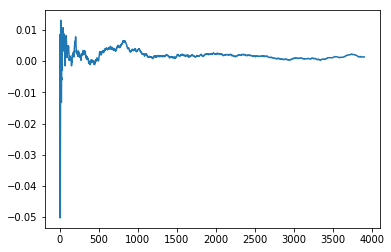

In [113]:
num_steps = 1000000
L = 16
T = 10
S, U, M, X, C = two_dim_ising(L, T, num_steps)
x_axis = np.linspace(0, num_steps/L**2, num_steps+1)

print("Magnetization converging to:", M[num_steps], "with system size:", L)
plt.plot(x_axis, M)
print("Onsager's result:", onsager(T))

Internal Energy converging to: -0.2041778125 with system size: 16


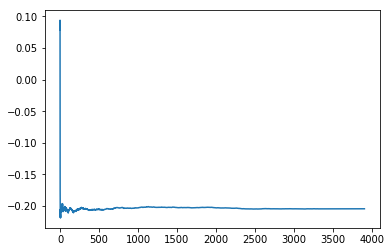

In [114]:
print("Internal Energy converging to:", U[num_steps], "with system size:", L)
plt.plot(x_axis, U)

Magnetization converging to: 0.00186228515625 with system size: 32
Onsager's result: 0


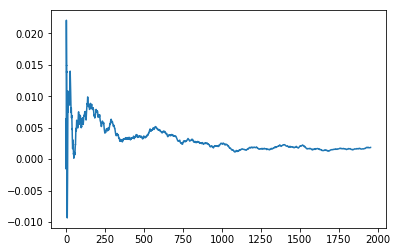

In [111]:
num_steps = 2000000
L = 32
T = 10
S, U, M, X, C = two_dim_ising(L, T, num_steps)
x_axis = np.linspace(0, num_steps/L**2, num_steps+1)

print("Magnetization converging to:", M[num_steps], "with system size:", L)
plt.plot(x_axis, M)
print("Onsager's result:", onsager(T))

Internal Energy converging to: -0.202484419922 with system size: 32


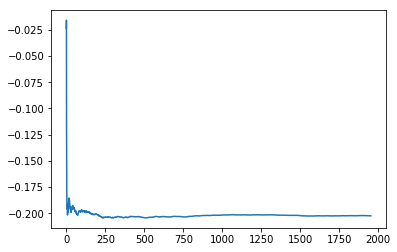

In [112]:
print("Internal Energy converging to:", U[num_steps], "with system size:", L)
plt.plot(x_axis, U)

Magnetic Susceptability converging to: 0.156374808866 with system size: 16


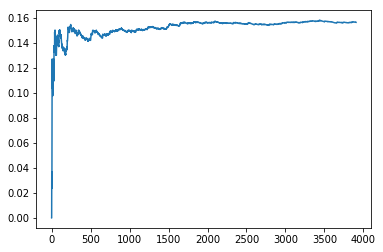

In [115]:
print("Magnetic Susceptability converging to:", X[num_steps], "with system size:", L)
plt.plot(x_axis, X)

Heat Capacity converging to: 0.0206306712098 with system size: 16


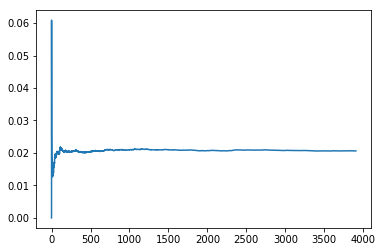

In [116]:
print("Heat Capacity converging to:", C[num_steps], "with system size:", L)
plt.plot(x_axis, C)

Text(0,0.5,'Magnetization')

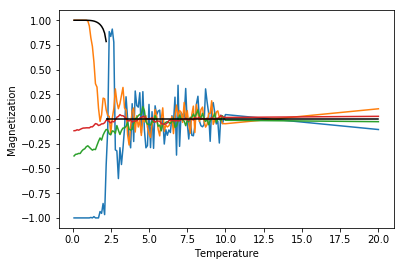

In [23]:
sample_steps = 100
L = np.array([8,16,32,64])
T = np.append([20,10],np.flip(np.arange(.1,9.9,.1),0))
M = np.zeros(np.size(T))
for i in range(np.size(L)):
    num_steps = 100000*L[i]
    S = random_S(L[i])
    for j in range(np.size(T)):
        if j > 0:
            num_steps = 1000
        n = 1
        S, U, M[j] = two_dim_ising_mag(S, L[i], T[j], num_steps, sample_steps)
    plt.plot(T, M)
plt.plot([2.2692,20],[0,0], 'k-')
plt.plot([2.2962,2.2692],[onsager(2.2961), 0], 'k-')
t = np.arange(0.1,2.2692,0.1)
plt.plot(t, onsager(t), color='black')
plt.xlabel('Temperature')
plt.ylabel('Magnetization')

In [ ]:
num_steps = 100000
L = 10
T = .1
S, U, M, X, C = two_dim_ising(L, T, num_steps)
graph_spins(S)

Spin up: White
Spin down: Black


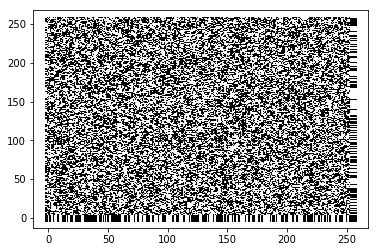

In [18]:
num_steps = 5000000
L = 256
T = 10
S, U, M, X, C = two_dim_ising(L, T, num_steps)
graph_spins(S)

Spin up: White
Spin down: Black


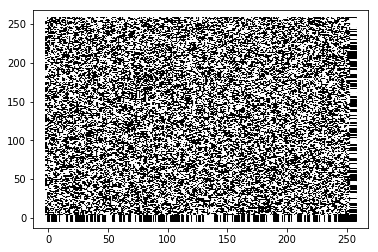

In [19]:
num_steps = 5000000
L = 256
L = 256
T = 8
S, U, M, X, C = two_dim_ising(L, T, num_steps)
graph_spins(S)

Spin up: White
Spin down: Black


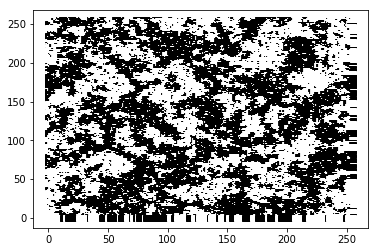

In [20]:
num_steps = 5000000
L = 256
T = 2.3
S, U, M, X, C = two_dim_ising(L, T, num_steps)
graph_spins(S)

Spin up: White
Spin down: Black


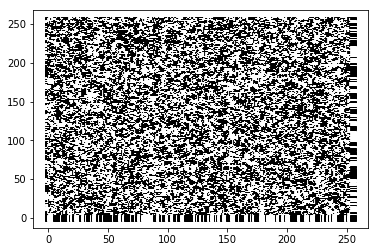

In [21]:
num_steps = 5000000
L = 256
L = 256
T = 4.0
S, U, M, X, C = two_dim_ising(L, T, num_steps)
graph_spins(S)

Spin up: White
Spin down: Black


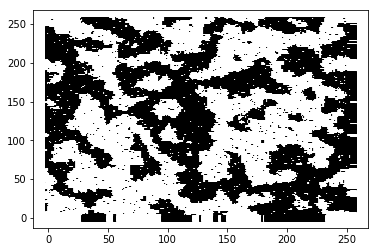

In [24]:
num_steps = 5000000
L = 256
L = 256
T = 1.8
S, U, M, X, C = two_dim_ising(L, T, num_steps)
graph_spins(S)